In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from sklearn.datasets import load_iris
import pandas as pd

# Load the iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

In [3]:
import torch as th

device = th.device('cuda' if th.cuda.is_available() else 'cpu')


In [4]:
X = iris_df.drop(columns=['target']).values
X = th.tensor(X, dtype=th.float32, device=device)

print(X.shape)


torch.Size([150, 4])


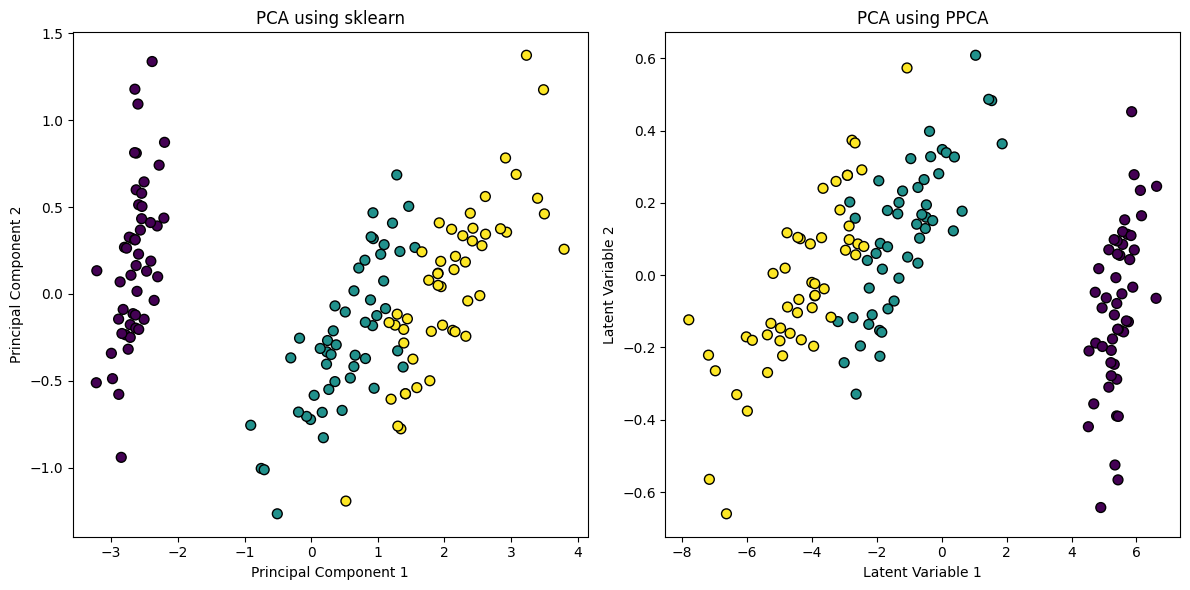

In [5]:
from sklearn.decomposition import PCA as SklearnPCA
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form, compute_Z
# Perform PCA using sklearn
sklearn_pca = SklearnPCA(n_components=2)
X_sklearn_pca = sklearn_pca.fit_transform(X.cpu().numpy())

# Perform Probabilistic PCA using ppca_closed_form
W_ppca, sigma_ml, mu_ppca = ppca_closed_form(X, q=2)
X_ppca = (X - mu_ppca) @ W_ppca



# Plotting the results
plt.figure(figsize=(12, 6))

# Subplot for sklearn PCA
plt.subplot(1, 2, 1)
plt.scatter(X_sklearn_pca[:, 0], X_sklearn_pca[:, 1], c=iris_df['target'], cmap='viridis', edgecolor='k', s=50)
plt.title('PCA using sklearn')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Subplot for PPCA
plt.subplot(1, 2, 2)
plt.scatter(X_ppca.cpu().numpy()[:, 0], X_ppca.cpu().numpy()[:, 1], c=iris_df['target'], cmap='viridis', edgecolor='k', s=50)
plt.title('PCA using PPCA')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')

plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Finished in 9 iterations with update size 9.124936246658246e-05


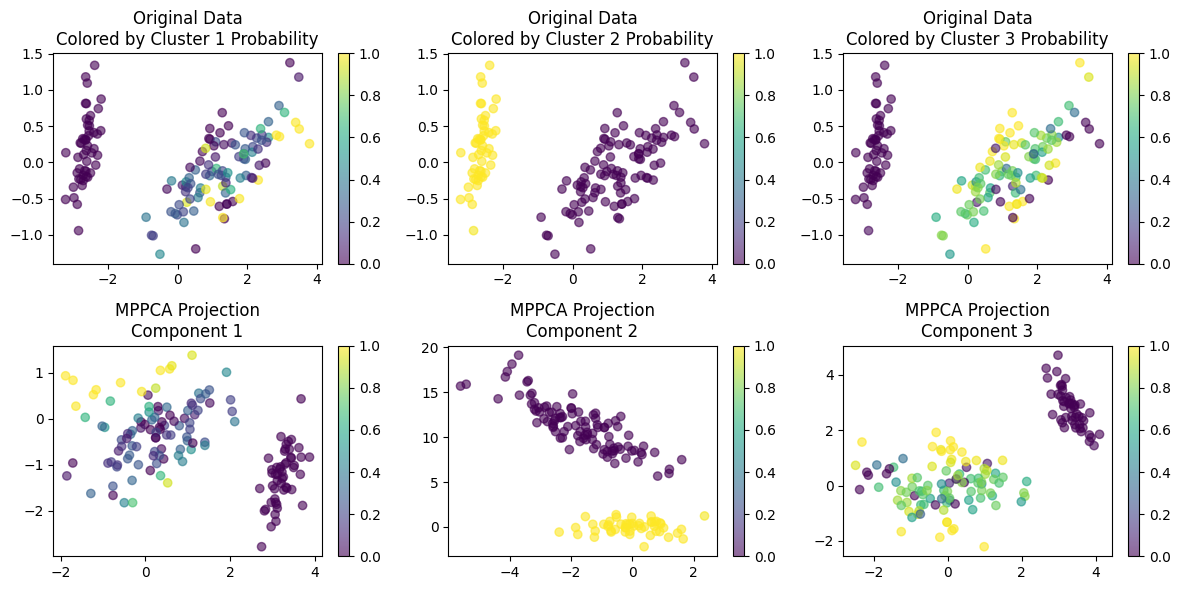

In [42]:
from src.ppca import mppca_full, compute_responsibilities, mppca
import numpy as np

# Perform Mixtures of Probabilistic Principal Component Analyzers (MPPCA)
k = 3  # Number of mixture components
q = 2  # Number of latent dimensions

W_mppca, mu_mppca, sigma_squared_mppca, pi = mppca(X, q=q, k=k)

# Compute latent variables Z using the computed parameters
Z_mppca = compute_Z(W_mppca, X, mu_mppca, sigma_squared_mppca, q)

# Visualizing the results
# Visualizing the results
fig = plt.figure(figsize=(12, 6))
responsibilities = compute_responsibilities(
    X, W_mppca, mu_mppca, sigma_squared_mppca, pi
)
# Original 3D data with probabilities for each cluster
for j in range(k):
    # Original data
    ax1 = fig.add_subplot(2, k, j + 1)
    scatter1 = ax1.scatter(
        X_sklearn_pca[:, 0],
        X_sklearn_pca[:, 1],
        c=responsibilities[j].cpu(),
        cmap="viridis",
        alpha=0.6,
        vmin=0,
        vmax=1,
    )
    ax1.set_title(f"Original Data\nColored by Cluster {j+1} Probability")
    plt.colorbar(scatter1, ax=ax1)

    # MPPCA projection
    ax2 = fig.add_subplot(2, k, j + k + 1)
    if q == 2:
        scatter2 = ax2.scatter(
            Z_mppca.cpu().numpy()[j, :, 0],
            Z_mppca.cpu().numpy()[j, :, 1],
            c=responsibilities[j].cpu(),
            cmap="viridis",
            alpha=0.6,
            vmin=0,
            vmax=1,
        )
    if q == 1:
        scatter2 = ax2.scatter(
            Z_mppca.cpu().numpy()[j, :, 0],
            np.zeros_like(Z_mppca.cpu().numpy()[j, :, 0]),
            c=responsibilities[j].cpu(),
            cmap="viridis",
            alpha=0.6,
            vmin=0,
            vmax=1,
        )
    ax2.set_title(f"MPPCA Projection\nComponent {j+1}")
    if q in [1, 2]:
        plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

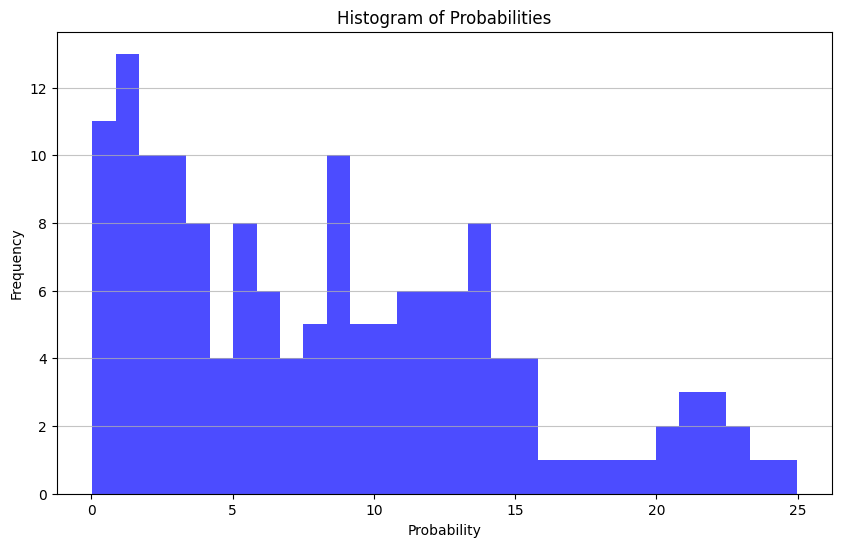

In [48]:
from src.ppca import compute_probabilities
probabilities = compute_probabilities(X, W_mppca, mu_mppca, sigma_squared_mppca, pi)
plt.figure(figsize=(10, 6))
plt.hist(probabilities.cpu().numpy(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


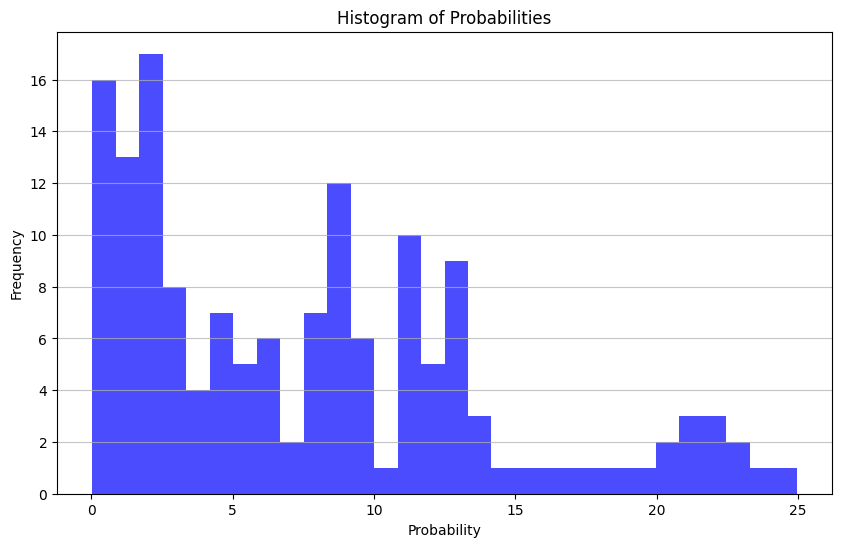

In [44]:
from src.ppca import compute_probabilities2
probabilities = compute_probabilities2(X, W_mppca, mu_mppca, sigma_squared_mppca, pi)
plt.figure(figsize=(10, 6))
plt.hist(probabilities[0].cpu().numpy(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


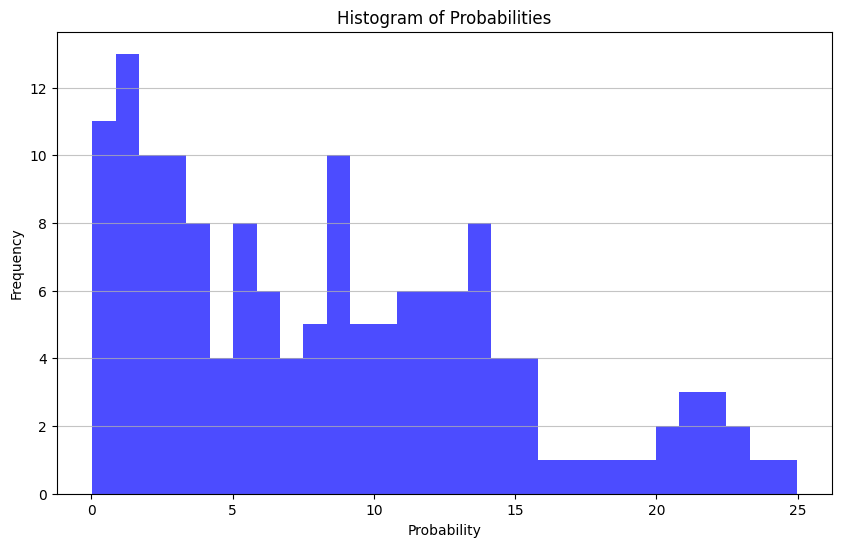

In [45]:
from src.ppca import compute_probabilities3
probabilities = compute_probabilities3(X, W_mppca, mu_mppca, sigma_squared_mppca, pi)
plt.figure(figsize=(10, 6))
plt.hist(probabilities.cpu().numpy(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


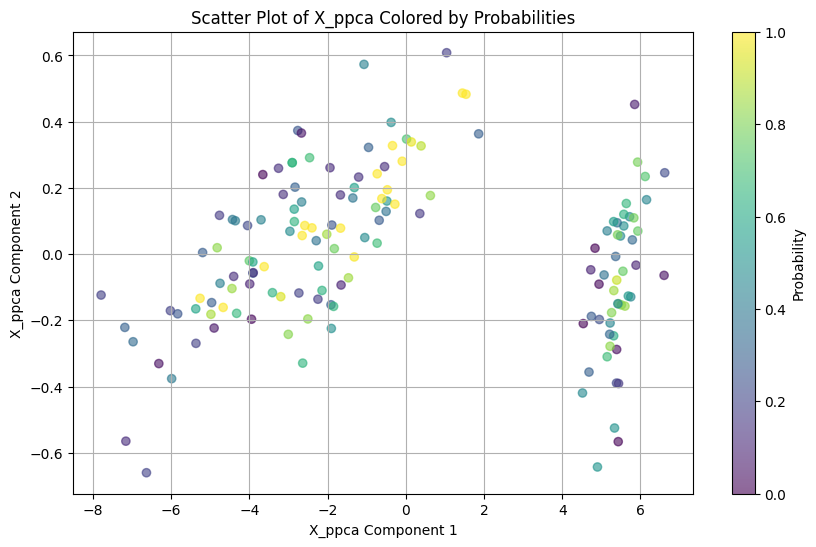

In [21]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_ppca.cpu().numpy()[:, 0],
    X_ppca.cpu().numpy()[:, 1],
    c=probabilities.cpu().numpy(),
    cmap="viridis",
    alpha=0.6,
    vmin=0,
    vmax=1,
)
plt.title("Scatter Plot of X_ppca Colored by Probabilities")
plt.colorbar(scatter, label='Probability')
plt.xlabel('X_ppca Component 1')
plt.ylabel('X_ppca Component 2')
plt.grid()
plt.show()



In [ ]:
pi = th.tensor([0.3, 0.7], device=device)
d = 1
q = 1
log_prob = (
        # th.log(pi).unsqueeze(1)
        - 0.5 * d * np.log(2 * np.pi)
        - 0.5 * d * th.log(sigma_squared).unsqueeze(1)
        - 0.5
        * th.einsum(
            "knD,knD->kn",
            th.einsum(
                "knd,kdD->knD",
                (X.unsqueeze(0) - mu_normals),
                sigma_normals.inverse(),
            ),
            (X.unsqueeze(0) - mu_normals),
        )
    )

In [ ]:
X = th.randn(100, 1)
sigma = th.eye(1)
mu = th.zeros(1)

log_prob = (
        - 0.5 * d * np.log(2 * np.pi)
        - 0.5 * d * th.log(sigma).unsqueeze(1)
        - 0.5
        * th.einsum(
            "nd,nd->n",
            th.einsum(
                "nd,dD->nD",
                (X - mu),
                sigma.inverse(),
            ),
            (X.unsqueeze(0) - mu),
        )
    )


In [53]:
def gaussian_density(x, mu, sigma):
    """Compute the Gaussian density for a given point x."""
    d = x.shape[-1]
    return (
        1
        / (np.sqrt(2 * np.pi) ** d * th.sqrt(th.det(sigma)))
        * th.exp(-0.5 * (x - mu) @ sigma.inverse() @ (x - mu).T)
    )

d = gaussian_density(th.randn(100, 1), th.zeros(1), th.eye(1))

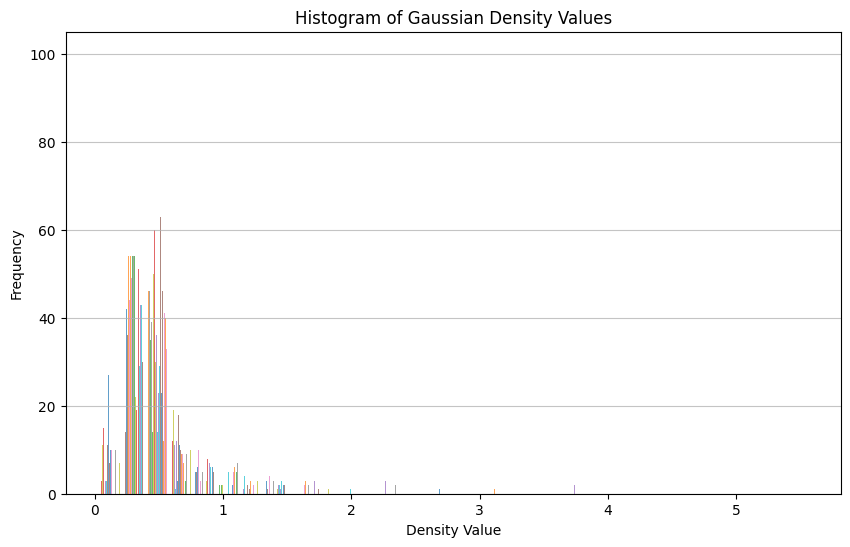

In [56]:
import matplotlib.pyplot as plt

# Generate a histogram of the values in d
plt.figure(figsize=(10, 6))
plt.hist(d.cpu().numpy(), bins=30, alpha=0.7)
plt.title('Histogram of Gaussian Density Values')
plt.xlabel('Density Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()